In [1002]:
import pandas as pd
import chinese_calendar as calendar 
import datetime
### STEP1：读取数据 ###

# 超参数
COLS_PREDICT = '60000305_amount'
COLS_PRICE = '60000305_price'
COLS_PRICE_OTHER = '60000305_price_other'
COLS_DROP = ['date', 'amount', COLS_PREDICT, COLS_PRICE_OTHER]
COLS_ALL = ['date', 'amount', 
            'text_day', 'text_night', 'high', 'low', 
            'wc_day', 'wd_day', 'wc_night', 'wd_night', 
            COLS_PRICE, COLS_PRICE_OTHER, COLS_PREDICT,
            ]

# 读取excel文件并获取指定列
df = pd.read_csv('../Data/竞争站分析-竞争站-全省.csv', usecols=COLS_ALL, encoding='GBK')
print(df.head())

       date       amount text_day text_night  high  low wc_day wd_day  \
0  2023-1-1  266411399.3       多云         多云     9    3    <3级    东北风   
1  2023-1-2  323691091.7       多云         多云     9   -1    <3级     东风   
2  2023-1-3  386823606.8        晴          晴    10   -2    <3级    东北风   
3  2023-1-4  271138326.9        晴         多云    11   -1    <3级     南风   
4  2023-1-5  281309373.7       多云         多云    13    2    <3级    东南风   

  wc_night wd_night  60000305_price  \
0      <3级       北风            7.76   
1      <3级      东北风            7.76   
2      <3级      东南风            7.76   
3      <3级      东南风            7.76   
4      <3级       西风            7.76   

                                60000305_price_other  60000305_amount  
0  [0.00, 4.40, 4.89, 4.96, 4.98, 5.00, 5.04, 5.0...      122586410.8  
1  [0.00, 4.40, 4.89, 4.96, 4.98, 5.00, 5.04, 5.0...      144215394.7  
2  [0.00, 4.40, 4.89, 4.96, 4.98, 5.00, 5.04, 5.0...      160029080.9  
3  [0.00, 4.40, 4.89, 4.96, 4.98, 5.00

18:11:30 - cmdstanpy - INFO - Chain [1] start processing
18:11:31 - cmdstanpy - INFO - Chain [1] done processing


           ds                                        holiday  lower_window  \
21 2023-01-01                                 New Year's Day           NaN   
32 2023-01-02                      New Year's Day (observed)           NaN   
22 2023-01-22             Chinese New Year (Spring Festival)           NaN   
23 2023-01-23             Chinese New Year (Spring Festival)           NaN   
24 2023-01-24             Chinese New Year (Spring Festival)           NaN   
33 2023-01-25  Chinese New Year (Spring Festival) (observed)           NaN   
35 2023-01-26          Day off (substituted from 01/28/2023)           NaN   
36 2023-01-27          Day off (substituted from 01/29/2023)           NaN   
29 2023-04-05                              Tomb-Sweeping Day           NaN   
25 2023-05-01                                      Labor Day           NaN   
37 2023-05-02          Day off (substituted from 04/23/2023)           NaN   
38 2023-05-03          Day off (substituted from 05/06/2023)    

d:\Python312\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
d:\Python312\Lib\site-packages\prophet\plot.py:196: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.tight_layout()
C:\Users\admin\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


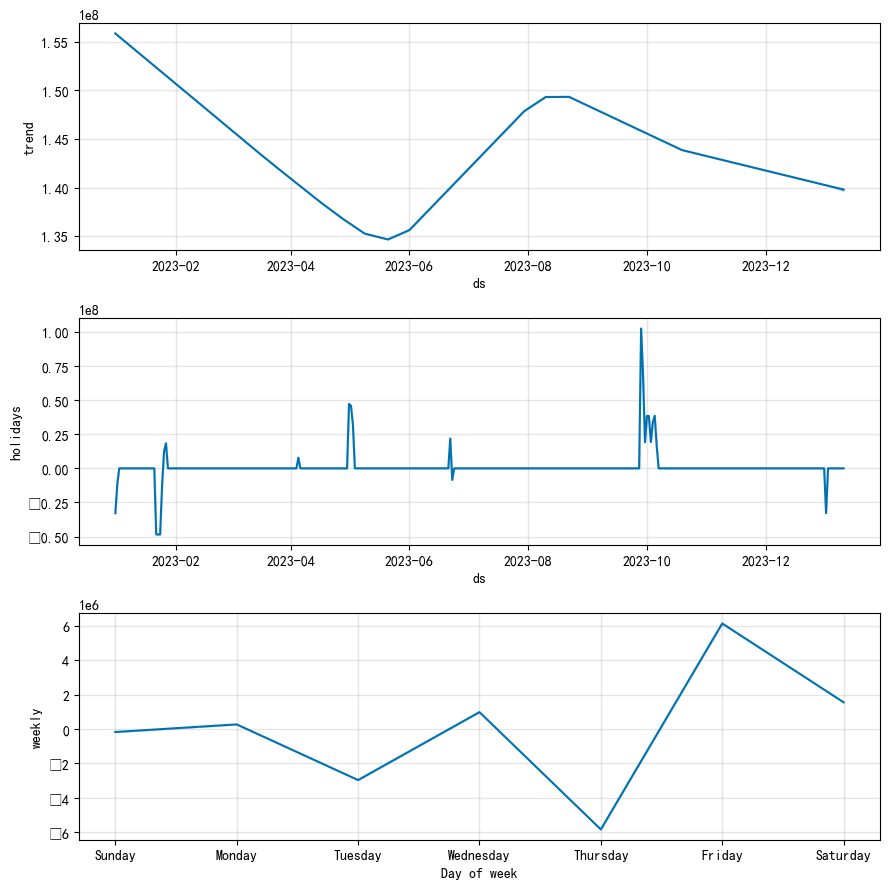

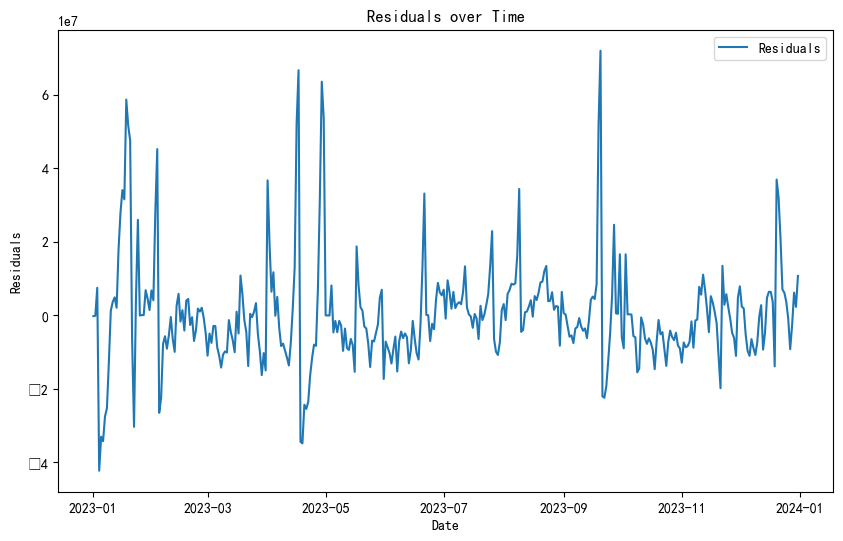

In [1003]:
from prophet import Prophet
from prophet.make_holidays import make_holidays_df
import matplotlib.pyplot as plt


# 第一步：构建输入DataFrame 
df_prophet = df[['date', COLS_PREDICT]].copy()      # 第一列必须被命名为“ds”并包含日期信息； 第二列必须被命名为“y”并包含观测结果。
df_prophet.rename(columns={'date':'ds', COLS_PREDICT:'y'}, inplace=True) 

# 第二步：训练模型
#model.add_country_holidays(country_name='CN')
holidays_df = make_holidays_df(year_list=[2023,2024], country='CN')
holidays_df.loc[holidays_df['holiday'] == 'Mid-Autumn Festival', 'lower_window'] = -1
holidays_df.loc[holidays_df['holiday'] == 'Mid-Autumn Festival', 'upper_window'] = 0
holidays_df.loc[holidays_df['holiday'] == 'National Day', 'lower_window'] = -1
holidays_df.loc[holidays_df['holiday'] == 'National Day', 'upper_window'] = 0
holidays_df = holidays_df.sort_values(by='ds')
model = Prophet(changepoint_range=0.8, 
                changepoint_prior_scale=0.1,
                holidays_prior_scale=1.0,
                holidays=holidays_df)
print(holidays_df)
model.fit(df_prophet)

# 第三步：进行预测
future = model.make_future_dataframe(10)  # 例如，预测未来365天
forecast = model.predict(future)

# 第四步：可视化节假日、趋势、周周期性的影响
from prophet.plot import plot_components
fig = plot_components(model, forecast)

# 第四步（可选）：计算残差,绘制残差图
forecast['residuals'] = df_prophet['y'] - forecast['yhat']
plt.figure(figsize=(10, 6))
plt.plot(forecast['ds'], forecast['residuals'], label='Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals over Time')
plt.legend()
plt.show()

In [1004]:
### 加入prophet的特征 ###
# 将 Prophet 的预测后形成的四列新特征，合并到原始 DataFrame
components_to_use = ['trend', 'holidays', 'weekly', 'yhat']
existing_components = [col for col in components_to_use if col in forecast.columns]
forecast_aligned = forecast.iloc[:len(df)][existing_components]     #虽然prophet预测了额外的日期，但我们不需要，在这里舍去。我们用的是它的分解趋势的能力，并作为特征。
print(f"原始的df.shape：{df.shape}")
print(f"forecast.shape：{forecast.shape}")

# 合并特征
df = pd.concat([df, forecast_aligned[existing_components]], axis=1)
print(f"合并后df.shape：{df.shape}")

原始的df.shape：(366, 13)
forecast.shape：(375, 95)
合并后df.shape：(366, 17)


In [1005]:
### STEP2：数据处理 ###
import chinese_calendar as  calendar
# 处理日期特征，引入若干个日期相关特征
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['amount_lag1'] = df['amount'].shift(1)   #创建滞后特征
df['amount_rolling_mean'] = df['amount'].shift(1).rolling(window=13).mean()   #过去n天的移动平均，滑动窗口。你需要shift一位以免使用当前天数的amount来预测，这样属于透题。


# 处理节假日,引入两个新特征
def check_holiday_workday(date):
    on_holiday, holiday_name = calendar.get_holiday_detail(date)
    return on_holiday, holiday_name
df[['on_holiday', 'holiday_name']] = df['date'].apply(lambda x: check_holiday_workday(x)).apply(pd.Series)
#print(df.head(30))
#print(df.iloc[260:281]) 

# 处理竞争站点信息
import json
def get_lowest_price(price_str):
    try:
        price_float = float(price_str)
        return price_float  # 只有一个价格直接返回
    except ValueError:
        # 使用 json.loads 将字符串转换为列表
        price_list = json.loads(price_str.replace("'", "\""))
        # 排序价格列表并返回第二低的价格
        sorted_prices = sorted(price_list)
        if len(sorted_prices) >= 2:
            return sorted_prices[1]  
        else:
            return sorted_prices[0]  
        # low_price = min(price_list)
        # return low_price
# 测试
# print(get_lowest_price("[5.84, 7.85, 8.25]"))
# print(get_lowest_price("8.25"))

df['competion_price'] = df[COLS_PRICE_OTHER].apply(get_lowest_price)
df['diff_price'] = (df[COLS_PRICE] - df['competion_price'])*10

# 处理类别特征
categorical_features_name = ['text_day','text_night','wc_day','wd_day','wc_night','wd_night','holiday_name']  
for col in categorical_features_name:
    df[col] = df[col].astype('category')

#print(df.info())
# pd.set_option('display.max_columns', None)
print(df.head())

        date       amount text_day text_night  high  low wc_day wd_day  \
0 2023-01-01  266411399.3       多云         多云     9    3    <3级    东北风   
1 2023-01-02  323691091.7       多云         多云     9   -1    <3级     东风   
2 2023-01-03  386823606.8        晴          晴    10   -2    <3级    东北风   
3 2023-01-04  271138326.9        晴         多云    11   -1    <3级     南风   
4 2023-01-05  281309373.7       多云         多云    13    2    <3级    东南风   

  wc_night wd_night  60000305_price  \
0      <3级       北风            7.76   
1      <3级      东北风            7.76   
2      <3级      东南风            7.76   
3      <3级      东南风            7.76   
4      <3级       西风            7.76   

                                60000305_price_other  60000305_amount  \
0  [0.00, 4.40, 4.89, 4.96, 4.98, 5.00, 5.04, 5.0...      122586410.8   
1  [0.00, 4.40, 4.89, 4.96, 4.98, 5.00, 5.04, 5.0...      144215394.7   
2  [0.00, 4.40, 4.89, 4.96, 4.98, 5.00, 5.04, 5.0...      160029080.9   
3  [0.00, 4.40, 4.89, 4.96, 

In [1006]:
### STEP3：XGBoost训练 ###
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


# 指定自变量和因变量
X = df.drop(columns=COLS_DROP, axis=1)
y = df[COLS_PREDICT]
print(f"训练集特征数: {X.shape}")

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 归一化，用独热编码分类变量，用MinMax归一化数值变量
scaler = MinMaxScaler()     #scaler = StandardScaler()
numerical_cols = X_train.select_dtypes(include=['int32', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
encoder = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numerical_cols),
        ('cat', encoder, categorical_cols)
    ])
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)
#print(X_train_preprocessed)

# 获取独热编码后的列名
categorical_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
numerical_names = numerical_cols
# 合并所有列名
all_names = numerical_names.tolist() + categorical_names
# 将预处理后的数据转换为数组形式，并确保形状正确
if X_train_preprocessed.shape[1]!= len(all_names):
    raise ValueError("Shape mismatch between data and column names.")
# 创建 DataFrame
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=all_names)
# print(X_train_preprocessed_df.head())

# 检查 y_train 中是否有 NaN 值
print(y_train.isnull().any())
y_train = y_train.fillna(y_train.mean())

# 使用xgb的XGBRegressor进行预测，指定目标为均方误差
model = xgb.XGBRegressor(objective='reg:squarederror', enable_categorical=True)
model.fit(X_train_preprocessed, y_train)

# 预测
y_pred = model.predict(X_test_preprocessed)


训练集特征数: (366, 23)
True


In [1007]:
### STEP4：XGBoost评估 ###
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from math import sqrt

# 计算均方根误差（RMSE）
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print(f'{COLS_PREDICT}的均方开方误差(RMSE): {rmse:.2f}')
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'{COLS_PREDICT}的平均绝对百分比误差 (MAPE): {mape:.2f}')

60000305_amount的均方开方误差(RMSE): 17060981.45
60000305_amount的平均绝对百分比误差 (MAPE): 0.07


C:\Users\admin\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


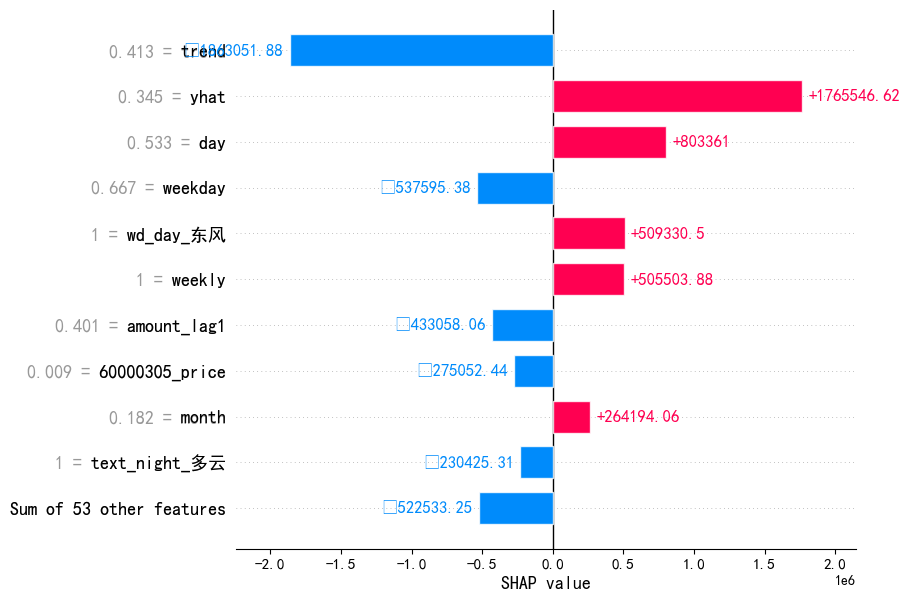

In [1009]:
import shap
shap.initjs()
# STEP 1：创建 TreeExplainer 解释器（因为这里要解释XGB的model）
explainer = shap.TreeExplainer(model)

# STEP 2：计算 SHAP 值
shap_values = explainer.shap_values(X_train_preprocessed)

# STEP 3：转换为explanation对象，再用shap.lots.bar显示
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, data=X_train_preprocessed,feature_names=X_train_preprocessed_df.columns.tolist())
shap.plots.bar(explanation[2], max_display=11)

# 可视化第一个样本的 SHAP 值（力图）
#shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_preprocessed[0,:])

# 可视化所有样本的特征重要性（汇总图）
# shap.summary_plot(shap_values, X_train_preprocessed, feature_names=X_train_preprocessed_df.columns.tolist())
